In [ ]:
import os
import zipfile
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import tensorflow as tf




In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import zipfile

zip_path = "/content/drive/MyDrive/waste_dataset_annotated.zip"
extract_path = "/content/waste_data_annotated/"

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Extracted contents:
waste_dataset_annotated


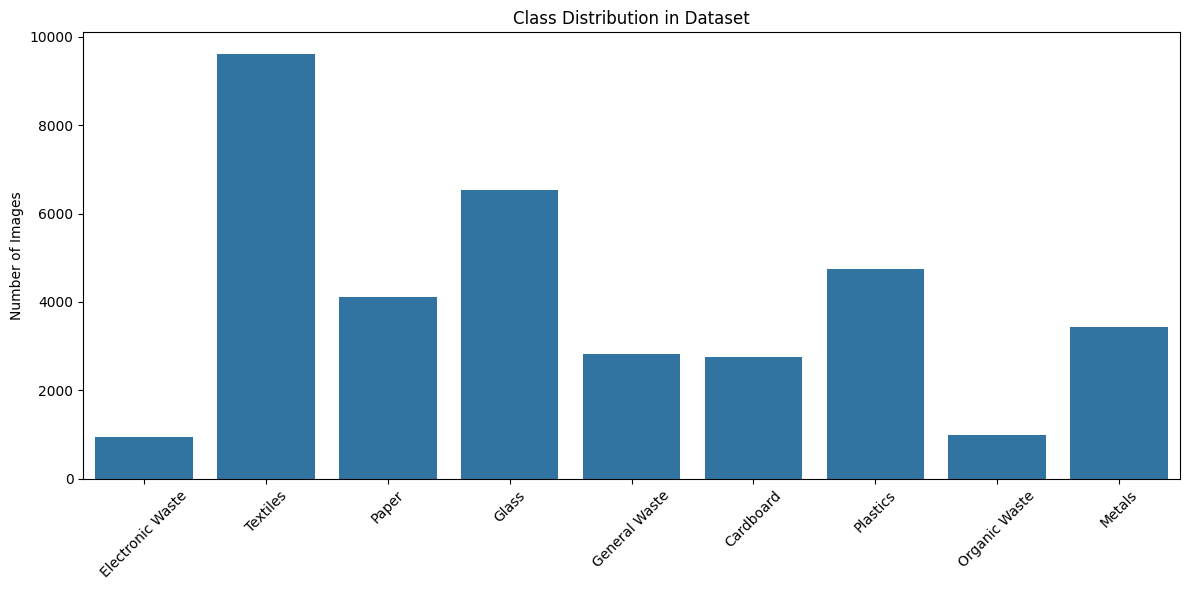

In [ ]:
# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted folder to find the real dataset folder
print("Extracted contents:")
!ls "/content/waste_data_annotated"

# Let’s say the actual data is inside 'waste_dataset_annotated' subfolder:
extract_path = os.path.join(extract_path, "waste_dataset_annotated")

# Step 3: Analyze dataset structure
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_dataset_structure(base_dir):
    class_distribution = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                img for img in os.listdir(class_path)
                if img.lower().endswith(('jpg', 'jpeg', 'png'))
            ])
            class_distribution[class_name] = num_images
    return class_distribution

dataset_stats = analyze_dataset_structure(extract_path)

# Step 4: Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=list(dataset_stats.keys()), y=list(dataset_stats.values()))
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image

# Paths
raw_dataset_path = extract_path  # Original images
cleaned_dataset_path = "/content/cleaned_dataset"  # New folder
os.makedirs(cleaned_dataset_path, exist_ok=True)

# Set fixed dimensions and format
TARGET_SIZE = (224, 224)

for class_name in os.listdir(raw_dataset_path):
    class_path = os.path.join(raw_dataset_path, class_name)
    cleaned_class_path = os.path.join(cleaned_dataset_path, class_name)
    os.makedirs(cleaned_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            if image_name.lower().endswith(('jpg', 'jpeg', 'png')):
                input_path = os.path.join(class_path, image_name)
                output_path = os.path.join(cleaned_class_path, image_name)

                try:
                    with Image.open(input_path) as img:
                        # Convert to RGB (3 channels)
                        img = img.convert("RGB")

                        # Resize to fixed size
                        img = img.resize(TARGET_SIZE)

                        # Save cleaned image
                        img.save(output_path)

                except Exception as e:
                    print(f"❌ Failed to process {input_path}: {e}")


In [ ]:

import os
import pandas as pd

# Define the cleaned dataset path
cleaned_dataset_path = "/content/cleaned_dataset"

# Folders to exclude (non-garbage class folders)
EXCLUDED_FOLDERS = {
    'annotations.json',
    'dataset2_annotation.json',
    'dataset3_annotation.json',
    'dataset4_annotation.json',
    'dataset5_annotation.json',
    'waste_dataset'
}

def build_dataframe(base_dir):
    data = []
    for folder_name in os.listdir(base_dir):
        if folder_name in EXCLUDED_FOLDERS:
            continue

        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.lower().endswith(('jpg', 'jpeg', 'png')):
                    data.append((os.path.join(folder_path, file), folder_name))

    return pd.DataFrame(data, columns=["filepath", "label"])

# Build the DataFrame
df = build_dataframe(cleaned_dataset_path)

# Display sample rows
print(df.head())
print(f"\nTotal images found: {len(df)}")
print(f"Classes found: {df['label'].nunique()}")
print(f"Class distribution:\n{df['label'].value_counts()}")


                                            filepath             label
0  /content/cleaned_dataset/Electronic Waste/Elec...  Electronic Waste
1  /content/cleaned_dataset/Electronic Waste/Elec...  Electronic Waste
2  /content/cleaned_dataset/Electronic Waste/Elec...  Electronic Waste
3  /content/cleaned_dataset/Electronic Waste/Elec...  Electronic Waste
4  /content/cleaned_dataset/Electronic Waste/Elec...  Electronic Waste

Total images found: 35948
Classes found: 9
Class distribution:
label
Textiles            9619
Glass               6528
Plastics            4754
Paper               4119
Metals              3431
General Waste       2811
Cardboard           2744
Organic Waste        997
Electronic Waste     945
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Perform stratified split (preserving class distribution)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,  # 20% for validation
    stratify=df["label"],
    random_state=42
)

# Show sizes
print(f"Training set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")

# Optional: Check class distribution in each set
print("\nClass distribution in training set:")
print(train_df["label"].value_counts())

print("\nClass distribution in validation set:")
print(val_df["label"].value_counts())


Training set size: 28758 images
Validation set size: 7190 images

Class distribution in training set:
label
Textiles            7695
Glass               5222
Plastics            3803
Paper               3295
Metals              2745
General Waste       2249
Cardboard           2195
Organic Waste        798
Electronic Waste     756
Name: count, dtype: int64

Class distribution in validation set:
label
Textiles            1924
Glass               1306
Plastics             951
Paper                824
Metals               686
General Waste        562
Cardboard            549
Organic Waste        199
Electronic Waste     189
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Perform stratified split (preserving class distribution)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,  # 20% for validation
    stratify=df["label"],
    random_state=42
)

# Show sizes
print(f"Training set size: {len(train_df)} images")
print(f"Validation set size: {len(val_df)} images")

# Show class distribution as percentages
print("\nClass distribution in training set (%):")
print((train_df["label"].value_counts(normalize=True) * 100).round(2))

print("\nClass distribution in validation set (%):")
print((val_df["label"].value_counts(normalize=True) * 100).round(2))


Training set size: 28758 images
Validation set size: 7190 images

Class distribution in training set (%):
label
Textiles            26.76
Glass               18.16
Plastics            13.22
Paper               11.46
Metals               9.55
General Waste        7.82
Cardboard            7.63
Organic Waste        2.77
Electronic Waste     2.63
Name: proportion, dtype: float64

Class distribution in validation set (%):
label
Textiles            26.76
Glass               18.16
Plastics            13.23
Paper               11.46
Metals               9.54
General Waste        7.82
Cardboard            7.64
Organic Waste        2.77
Electronic Waste     2.63
Name: proportion, dtype: float64


In [ ]:
dataset_path = "/content/cleaned_dataset"
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define generators (only rescale)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Use your previously split DataFrames: train_df, val_df
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 28758 validated image filenames belonging to 9 classes.
Found 7190 validated image filenames belonging to 9 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class indices from the generator
class_indices = train_generator.class_indices  # e.g., {'Cardboard': 0, 'Electronic Waste': 1, ...}

# Invert the dict: {0: 'Cardboard', 1: 'Electronic Waste', ...}
index_to_label = {v: k for k, v in class_indices.items()}

# Get class labels from training dataframe
labels = train_df['label']

# Compute class weights using sklearn (returns label -> weight)
class_weights_raw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
label_to_weight = dict(zip(np.unique(labels), class_weights_raw))

# Build final class_weights dict using class indices
class_weights_dict = {
    class_indices[label]: label_to_weight[label]
    for label in label_to_weight
}

# ✅ Now this dict is ready to be used in model.fit()
print("✅ Final class_weights_dict (index → weight):\n")
for idx, weight in class_weights_dict.items():
    print(f"Class {idx:2d} ({index_to_label[idx]:17s}): {weight:.2f}")


✅ Final class_weights_dict (index → weight):

Class  0 (Cardboard        ): 1.46
Class  1 (Electronic Waste ): 4.23
Class  2 (General Waste    ): 1.42
Class  3 (Glass            ): 0.61
Class  4 (Metals           ): 1.16
Class  5 (Organic Waste    ): 4.00
Class  6 (Paper            ): 0.97
Class  7 (Plastics         ): 0.84
Class  8 (Textiles         ): 0.42


In [ ]:
# Import necessary libraries and modules
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Define the number of classes
num_classes = len(train_generator.class_indices)

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

# Add a classification layer on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) # Optional: Add a dense layer
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model_efficientnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model for the initial training of the top layer
model_efficientnet.compile(
    optimizer='adam',  # Use a standard optimizer for the initial phase
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001
)

# Train only the top layer (freeze base model)
base_model.trainable = False

history_effnet = model_efficientnet.fit(
    train_generator,
    epochs=10,  # You can adjust this based on convergence
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)


# Unfreeze for fine-tuning
base_model.trainable = True

# Compile again (with smaller LR)
model_efficientnet.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',  # Change this from 'sparse_categorical_crossentropy'
    metrics=['accuracy']
)

# Continue training
history_effnet_finetune = model_efficientnet.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr]
)

# Save the fine-tuned model
model_efficientnet.save("fine_tuned_efficientnet.h5")
print("\nFine-tuned EfficientNet model saved as fine_tuned_efficientnet.h5")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


899/899 ━━━━━━━━━━━━━━━━━━━━ 98s 83ms/step - accuracy: 0.0981 - loss: 2.2188 - val_accuracy: 0.0782 - val_loss: 2.1954 - learning_rate: 0.0010
Epoch 2/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 52s 58ms/step - accuracy: 0.0811 - loss: 2.2056 - val_accuracy: 0.2676 - val_loss: 2.1946 - learning_rate: 0.0010
Epoch 3/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 54s 60ms/step - accuracy: 0.1336 - loss: 2.2116 - val_accuracy: 0.0764 - val_loss: 2.1951 - learning_rate: 0.0010
Epoch 4/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 54s 59ms/step - accuracy: 0.1301 - loss: 2.1841 - val_accuracy: 0.0764 - val_loss: 2.1986 - learning_rate: 0.0010
Epoch 5/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 55s 61ms/step - accuracy: 0.0626 - loss: 2.2049 - val_accuracy: 0.1146 - val_loss: 2.1974 - learning_rate: 0.0010
Epoch 6/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 53s 59ms/step - accuracy: 0.1078 - loss: 2.2049 - val_accuracy: 0.1146 - val_loss: 2.1971 - learning_rate: 2.0000e-04
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 55s 61ms/step - accuracy: 0.1029 - loss: 2.


Fine-tuned EfficientNet model saved as fine_tuned_efficientnet.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step
🔍 Classification Report:

                  precision    recall  f1-score   support

       Cardboard      0.887     0.925     0.906       549
Electronic Waste      0.973     0.968     0.971       189
   General Waste      0.950     0.922     0.936       562
           Glass      0.975     0.940     0.957      1306
          Metals      0.877     0.975     0.923       686
   Organic Waste      0.956     0.985     0.970       199
           Paper      0.929     0.932     0.930       824
        Plastics      0.966     0.923     0.944       951
        Textiles      0.988     0.986     0.987      1924

        accuracy                          0.952      7190
       macro avg      0.944     0.951     0.947      7190
    weighted avg      0.953     0.952     0.952      7190



/tmp/ipython-input-13-1865310949.py:41: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


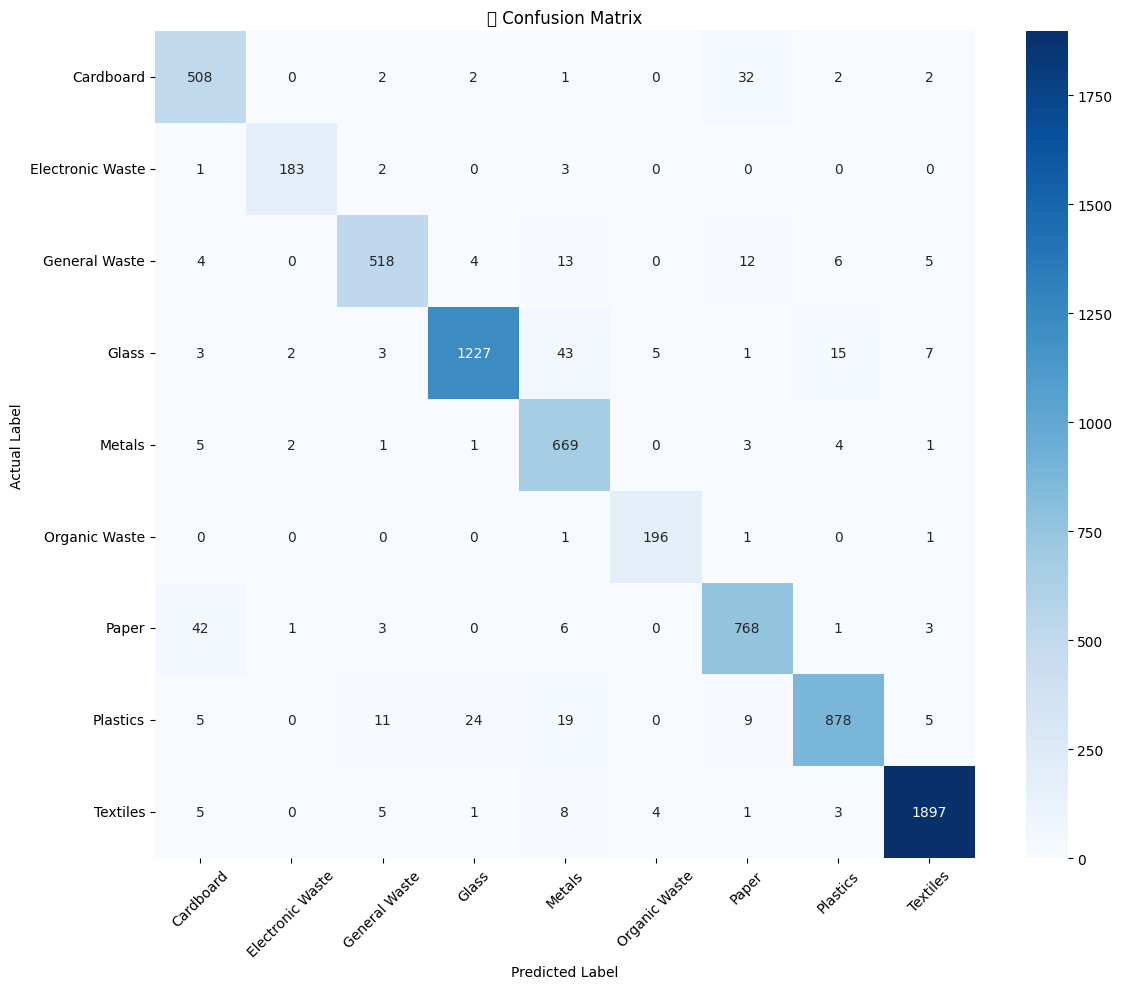

/tmp/ipython-input-13-1865310949.py:65: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-13-1865310949.py:65: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


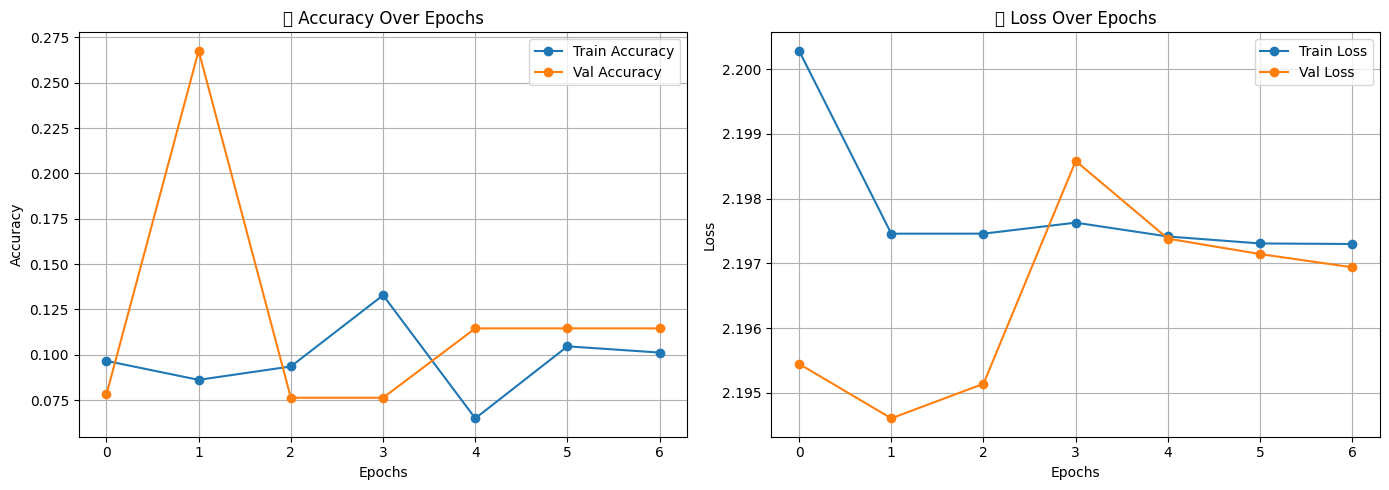


📊 Per-Class Accuracy:

Metals              : 97.52%
General Waste       : 92.17%
Organic Waste       : 98.49%
Glass               : 93.95%
Cardboard           : 92.53%
Paper               : 93.20%
Plastics            : 92.32%
Textiles            : 98.60%
Electronic Waste    : 96.83%


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Ground-truth labels
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Predict probabilities
y_pred_probs = model_efficientnet.predict(val_generator, verbose=1)

# Convert to class indices
y_pred = np.argmax(y_pred_probs, axis=1)
report = classification_report(
    y_true,
    y_pred,
    target_names=class_labels,
    digits=3
)

print("🔍 Classification Report:\n")
print(report)
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("🧩 Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_effnet.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_effnet.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('📈 Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_effnet.history['loss'], label='Train Loss', marker='o')
plt.plot(history_effnet.history['val_loss'], label='Val Loss', marker='o')
plt.title('📉 Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
from collections import defaultdict

correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

for i in range(len(y_true)):
    label = y_true[i]
    pred = y_pred[i]
    total_per_class[label] += 1
    if label == pred:
        correct_per_class[label] += 1

print("\n📊 Per-Class Accuracy:\n")
for label_index, total in total_per_class.items():
    acc = correct_per_class[label_index] / total
    label_name = index_to_label[label_index]
    print(f"{label_name:20s}: {acc*100:.2f}%")


In [ ]:
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model("fine_tuned_efficientnet.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Quantization for speed (float16)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

# Save the model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpqwm05qku'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  132983300948432: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132983300948048: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132984674338384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132984674338192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132984674340112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132984674342608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132984674341264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132984674344144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132984674346256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132984674347600: TensorSpec(shape=(), dtype=tf.resource, name=None)